# Sentiment analysis

One of the most popular and frequent tasks when it comes to dealing with text, it also brings us back to the good old binary classification challenge. We will look at the processed data set of movie reviews, originally gathered and studied by Maas et al (https://www.aclweb.org/anthology/P11-1015). Movie comments are labeled as "1" for positive reviews and "0" for negative. Let's consider methods from simplest to more complex:
 
 1. Dictionary based
 2. Logit with vectorized inputs
 3. w2v embeddings trained within model + GRU
 4. GloVe pretrained embeddings + GRU
 5. GloVe pretrained embeddings + GRU + bidirectinoal wrapper


In [1]:
import pandas as pd
import numpy as np

# Library re provides regular expressions functionality
import re

# Library beatifulsoup4 handles html
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from nltk.classify.scikitlearn import SklearnClassifier

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/hauptjoh/anaconda/envs/adams/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [70]:
#text document for a difference, IMDB database snippet, positive (1), negative (0)
df=pd.read_csv("imdb_labelled.txt",names=['sentence', 'label'], sep='\t')
df.shape

(748, 2)

In [71]:
df.iloc[0,0]

'A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  '

In [72]:
df.head(10)

,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted two hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


(array([362.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 386.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

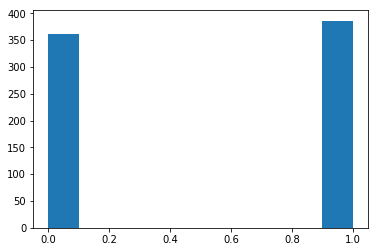

In [5]:
plt.hist(df["label"])
#for once we are balanced

### 1. Classic example of sentiment analysis using dictionary

A simple approach to rate the sentiment of a text is to literally model it as the sum of its parts through the sentiment of each word. AFINN is an English word listed developed by Finn Årup Nielsen. Words scores range from minus five (negative) to plus five (positive). The English language dictionary consists of 2,477 coded words.

In [73]:
from afinn import Afinn

We look up the sentiment score for each word in turn and sum up the sentiment values over words.

In [7]:
afinn = Afinn(language='en')
print(afinn.score("What a marvelous evening, the weather is simply delightful. Wonderful!"))
print(afinn.score("I am devastated, the donuts are not what they used to be, what a horrendous taste"))
print(afinn.score("To be or not to be, that is the question.."))

10.0
-5.0
0.0


In [75]:
afinn.score('average')

-2.0

In [74]:
df['afinn_score'] = df['sentence'].apply(afinn.score)
df['afinn_score'].describe() # overall rather positive

count    748.000000
mean       0.878342
std        5.329307
min      -15.000000
25%       -2.000000
50%        0.000000
75%        3.000000
max       77.000000
Name: afinn_score, dtype: float64

In [77]:
#Let's calculate the accuracy, we will say that if score is positive then it's a good review
df['yhat'] = np.where(df['afinn_score']>0, 1, 0)

In [78]:
df.head(10)

,sentence,label,afinn_score,yhat
0,"A very, very, very slow-moving, aimless movie ...",0,-2.0,0
1,Not sure who was more lost - the flat characte...,0,-3.0,0
2,Attempting artiness with black & white and cle...,0,-5.0,0
3,Very little music or anything to speak of.,0,0.0,0
4,The best scene in the movie was when Gerardo i...,1,3.0,1
5,"The rest of the movie lacks art, charm, meanin...",0,1.0,1
6,Wasted two hours.,0,-2.0,0
7,Saw the movie today and thought it was a good ...,1,6.0,1
8,A bit predictable.,0,0.0,0
9,Loved the casting of Jimmy Buffet as the scien...,1,3.0,1


In [79]:
from sklearn.metrics import accuracy_score

score_dict=accuracy_score(df['label'], df['yhat'])
print("Accuracy:", score_dict)

Accuracy: 0.7700534759358288


### 2. Baseline model: logit

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['label'], test_size=0.25, random_state=111)

We will use vectorization for our baseline model: take the words of each sentence and create a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words.

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

In [83]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [84]:
X_train.shape

(561, 2675)

In [86]:
X_train[0:1,:]

<1x2675 sparse matrix of type '<class 'numpy.int64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [87]:
print(X_train[0])

  (0, 102)	2
  (0, 112)	1
  (0, 116)	1
  (0, 322)	1
  (0, 621)	1
  (0, 863)	1
  (0, 1064)	1
  (0, 1089)	1
  (0, 1154)	1
  (0, 1172)	1
  (0, 1496)	1
  (0, 1514)	1
  (0, 1528)	1
  (0, 1569)	1
  (0, 1571)	1
  (0, 1592)	1
  (0, 1605)	1
  (0, 1961)	1
  (0, 2147)	1
  (0, 2313)	1
  (0, 2333)	1
  (0, 2358)	1
  (0, 2590)	1
  (0, 2645)	1


In [19]:
#vectorizer.vocabulary_

In [88]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="lbfgs")
classifier.fit(X_train, y_train)
score_lr = classifier.score(X_test, y_test)

print("Accuracy:", score_lr)

Accuracy: 0.7433155080213903


Caveat: The above model is not the best conceivable benchmark, but a good guess. A TF-IDF approach should improve the results further.

### 3. Tokenization and Lemmatization

Let's see if a model of word similarity and non-linear effects will get us further. We are cheating by also introducing lemmatization to reduce the computational time by reducing the effective number of tokens. 

In [89]:
lemmatizer = WordNetLemmatizer()

The WordNet lemmatizer distinguishes between word types. The following helper function uses nltk to determine the word type and return its abbreviation.

In [91]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [92]:
[get_wordnet_pos(x) for x in ["house", "car", "go", "nice","nicely"]]

['n', 'n', 'v', 'a', 'r']

In [94]:
def clean_sentences(df):
    reviews = []

    for sent in df:
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
  
        #lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [95]:
#from https://www.kaggle.com/chiranjeevbit/movie-review-prediction
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

train_sentences = clean_sentences(df['sentence'])
print(len(train_sentences))#748

748


In [96]:
df.sentence[12]

'The Songs Were The Best And The Muppets Were So Hilarious.  '

In [97]:
train_sentences[12]

['the',
 'song',
 'be',
 'the',
 'best',
 'and',
 'the',
 'muppets',
 'be',
 'so',
 'hilarious']

In [28]:
import pickle

# 'wb' specifies 'write (open in binary mode)'
# binary mode is important on Win for non-text files
with open('review.pkl','wb') as path_name:
    pickle.dump(train_sentences, path_name)

# 'rb' specifies 'read (open in binary mode)'
with open('review.pkl','rb') as path_name:
    clean_list = pickle.load(path_name)
    print(clean_list[10])


['and', 'those', 'baby', 'owl', 'be', 'adorable']


### 3. w2v embeddings + GRU

#### Training word vectors


We'll use gensim to train the embeddings using Word2Vec in a first step. Why is this helpful? We hope that some of the information that is necessary to predict context words is also helpful for our original task. 

In [98]:
from gensim.models import Word2Vec    

emb=100 # size of embedding dimension

# Train a Word2Vec model
model = Word2Vec(train_sentences, 
                 min_count=1,## min_count means the frequency benchmark, if =2 and word is used only once - it's not included
                 window=5, #the size of context
                 iter =100, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size=emb, #size of embedding
                 workers=3)#for parallel computing
# summarize the loaded model
print(model)
words=list(model.wv.vocab)

Word2Vec(vocab=2651, size=100, alpha=0.025)


In [30]:
embs="movie_embeddings.txt"
model.wv.save_word2vec_format(embs, binary=False)

/Users/hauptjoh/anaconda/envs/adams/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Preparing embeddings for the classifier training
We will need to make sure that embeddings constitute a proper 'lookup table' for the use in NN.
Inspiration taken from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [99]:
train_sentences[1]

['not',
 'sure',
 'who',
 'be',
 'more',
 'lose',
 'the',
 'flat',
 'character',
 'or',
 'the',
 'audience',
 'nearly',
 'half',
 'of',
 'whom',
 'walk',
 'out']

In [100]:
from keras.preprocessing.text import Tokenizer

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_sentences)
seq=tokenizer_obj.texts_to_sequences(train_sentences)
seq[1]

[24, 520, 53, 2, 61, 284, 1, 711, 32, 50, 1, 337, 1099, 285, 5, 712, 521, 48]

In [101]:
longestsentence=max([len(s.split()) for s in df["sentence"]])
print(longestsentence)

1390


In [102]:
from keras.preprocessing.sequence import pad_sequences
padded=pad_sequences(seq,longestsentence)

In [103]:
sentiment=df["label"]
print(padded.shape) # 748 reviews, with max length od 1390 tokens
print(sentiment.shape)

(748, 1390)
(748,)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(padded, sentiment, test_size=0.25, random_state=111)

Now we can do the mapping to create your lookup table. The critical issue is that the word indices must match between our pretrained embeddings and the model's embedding matrix.

In [105]:
embs

'movie_embeddings.txt'

The following approach to load the embeddings that we have previously saved as a text file is a little hacky. We the text file in line by line and put them into a dictionary.

Step by step example: 

In [38]:
loaded_embs=open("movie_embeddings.txt")

In [39]:
next(loaded_embs)

'2651 100\n'

In [40]:
loaded_embs.close()

And for the complete file:

In [41]:
embeddings_index={}
with open("movie_embeddings.txt") as loaded_embs:
    for line in loaded_embs:
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:])
        embeddings_index[word]=coefs

In [42]:
embeddings_index["movie"]

array(['0.7002084', '0.91902596', '1.0331162', '-0.36113247',
       '-0.6028371', '0.90798396', '-0.37949166', '-0.8602604',
       '0.40564546', '0.25128397', '-0.15228094', '0.83823264',
       '-0.30462024', '-1.1524318', '0.3633499', '0.040245138',
       '-0.32323387', '0.5324815', '-0.055528942', '0.4812467',
       '0.1748874', '0.28951162', '0.8733927', '-1.3366427',
       '0.0033434748', '0.09219933', '0.64927876', '-0.22890049',
       '-0.8652936', '0.38316628', '-0.39808464', '-1.0970116',
       '1.0841267', '-0.50362027', '-0.21924332', '0.070360355',
       '-0.63640505', '0.9530211', '-0.7131159', '-0.118773974',
       '-1.104995', '-0.038863186', '0.45446792', '0.8166238',
       '0.25114492', '1.1627884', '0.9582804', '-0.68942237',
       '-0.5757062', '-0.61781967', '-0.7815124', '-0.87729895',
       '-0.068175495', '-0.67342544', '-0.18095785', '0.1501756',
       '-0.62858075', '0.3855334', '0.57831705', '0.16358326',
       '0.5250392', '-0.04555469', '-0.607

Since we are not working with the original words but their indices, we need to be careful to preserve the original mapping from words to integer indices.

In [43]:
word_index=tokenizer_obj.word_index
# here is the size of vocab/number of unique tokens
len(word_index)#2651

2651

In [44]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words, emb))

In [45]:
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector=embeddings_index[word]
    #dealing with words that we have not embeddings for
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
#embedding_matrix is our lookup table
print(embedding_matrix.shape)
print(num_words)

(2652, 100)
2652


#### Setting up and training the classifier network

In [46]:
epochs=25

In [106]:
embedding_layer=Embedding(num_words, #size of vocab
                          emb, #size of embedding 
                          embeddings_initializer=Constant(embedding_matrix), #weights to start with, and not touch during training
                          input_length=longestsentence, 
                          trainable=False  # do no update these weights
                         )

model=Sequential()                        
model.add(embedding_layer)
model.add(GRU(16))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1390, 100)         265200    
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 270,833
Trainable params: 5,633
Non-trainable params: 265,200
_________________________________________________________________


In [48]:
history=model.fit(X_train,y_train, batch_size=64, epochs=epochs, validation_split=0.3, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 392 samples, validate on 169 samples
Epoch 1/25
392/392 [==============================] - 11s 29ms/step - loss: 0.7201 - acc: 0.4872 - val_loss: 0.6908 - val_acc: 0.5325
Epoch 2/25
392/392 [==============================] - 8s 21ms/step - loss: 0.6907 - acc: 0.5510 - val_loss: 0.6744 - val_acc: 0.6154
Epoch 3/25
392/392 [==============================] - 8s 20ms/step - loss: 0.6710 - acc: 0.5842 - val_loss: 0.6571 - val_acc: 0.6213
Epoch 4/25
392/392 [==============================] - 8s 20ms/step - loss: 0.6560 - acc: 0.6122 - val_loss: 0.6439 - val_acc: 0.6154
Epoch 5/25
392/392 [==============================] - 8s 21ms/step - loss: 0.6441 - acc: 0.6327 - val_loss: 0.6331 - val_acc: 0.6331
Epoch 6/25
392/392 [==============================] - 8s 20ms/step - loss: 0.6361 - acc: 0.6327 - val_loss: 0.6227 - val_acc: 0.6686
Epoch 7/25
392/392 [==============================] - 8s 22ms/step - loss: 0.6269 - acc: 0.6378 - val_loss:

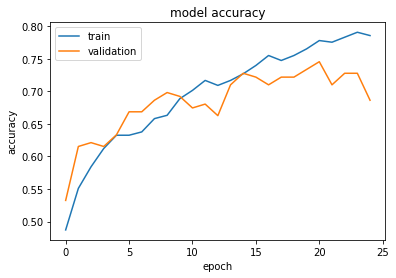

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [50]:
model.save_weights("ex11-GRU_word2vec_reviews.h5")
#print("Saved model to disk")

#model.load_weights("ex11-GRU_word2vec_reviews.h5")
#print("Loaded model from disk")

scores={}
score_emb = model.evaluate(X_test, y_test, verbose=0)
scores["GRU_word2vec_reviews"] = score_emb
print('Test loss:', score_emb[0])
print('Test accuracy:', score_emb[1])


Test loss: 0.6003967580948284
Test accuracy: 0.6791443869391864


#### Finetuning the model

Let's try to do proper finetuning by transfering the GRU weights.

In [51]:
GRUw = model.layers[1].get_weights()
#install tf-nightly

In [52]:
model2=Sequential()
embedding_layer=Embedding(num_words, #size of vocab
                         emb, #size of embedding 
                         embeddings_initializer=Constant(embedding_matrix), #weights to start with, and not nouch during training
                         input_length=longestsentence, 
                         trainable=True  
                         )
model2.add(embedding_layer)
#model2.add(Dropout(0.2))
model2.add(GRU(16, weights=GRUw)) #  dropout=0.1, recurrent_dropout=0.1, for recurring unit and recurrant state
model2.add(Dense(1, activation="sigmoid"))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1390, 100)         265200    
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 270,833
Trainable params: 270,833
Non-trainable params: 0
_________________________________________________________________


In [53]:
history2=model2.fit(X_train,y_train, batch_size=64, epochs=epochs, validation_split=0.2, verbose=1)

Train on 448 samples, validate on 113 samples
Epoch 1/25
448/448 [==============================] - 10s 21ms/step - loss: 0.7644 - acc: 0.3192 - val_loss: 0.7128 - val_acc: 0.4956
Epoch 2/25
448/448 [==============================] - 9s 19ms/step - loss: 0.6966 - acc: 0.5089 - val_loss: 0.6818 - val_acc: 0.5487
Epoch 3/25
448/448 [==============================] - 8s 19ms/step - loss: 0.6538 - acc: 0.6429 - val_loss: 0.6614 - val_acc: 0.5841
Epoch 4/25
448/448 [==============================] - 8s 18ms/step - loss: 0.6220 - acc: 0.7210 - val_loss: 0.6461 - val_acc: 0.6106
Epoch 5/25
448/448 [==============================] - 8s 18ms/step - loss: 0.5948 - acc: 0.7478 - val_loss: 0.6368 - val_acc: 0.6106
Epoch 6/25
448/448 [==============================] - 8s 18ms/step - loss: 0.5675 - acc: 0.7746 - val_loss: 0.6298 - val_acc: 0.6106
Epoch 7/25
448/448 [==============================] - 9s 19ms/step - loss: 0.5430 - acc: 0.7835 - val_loss: 0.6186 - val_acc: 0.6283
Epoch 8/25
448/448 [==

In [54]:
#model2=loaded_model.load_weights("ex11-GRU_word2vec_reviews_finetuning.h5")
#print("Loaded model from disk")

In [55]:
score_fine_proper = model2.evaluate(X_test, y_test, verbose=0)
scores["GRU_word2vec_reviews_finetuned"] = score_fine_proper
print('Test loss:', score_fine_proper[0])
print('Test accuracy:', score_fine_proper[1])

Test loss: 0.5804643240523211
Test accuracy: 0.7754010672875267


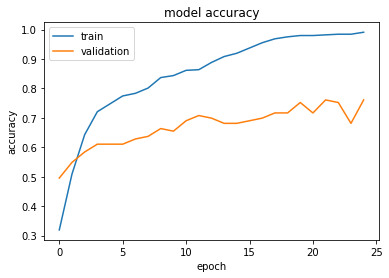

In [56]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [57]:
model2.save_weights("ex11-GRU_word2vec_reviews_finetuning.h5")
print("Saved model to disk")

Saved model to disk


### Loading pretrained weights
Building your own embeddings might not be the smartest thing. In case the vocabulary you will be working with is not too specific, you can always use the pretrained embeddings. GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics (https://nlp.stanford.edu/projects/glove/). Often you get to choose the length of pretrained embeddings, we will stick to 100.

The emebddings that we use here have been trained on Wikipedia articles.

In [58]:
embeddings_index = {}
with open('/Users/hauptjoh/Downloads/glove.6B/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Apart from being careful to adjust the word indices, there will be words in new data that we haven't seen. Here we include an all-zero embedding for these, but it may be better to learn a proper embedding for an UNKNOWN/RARE token. 

In [59]:
gloved = np.zeros((len(word_index) + 1, emb))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # CAREFUL: Words not found in embedding index will be all-zeros.
        gloved[i] = embedding_vector

In [60]:
embedding_layer2 = Embedding(num_words,
                            emb,
                            weights=[gloved],
                            input_length=longestsentence,
                            trainable=False)

In [61]:
model3=Sequential()
model3.add(embedding_layer2)
#model3.add(Dropout(0.25))
model3.add(GRU(16))
#model3.add(Dropout(0.25))
model3.add(Dense(1, activation="sigmoid"))
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.summary()

history3=model3.fit(X_train,y_train, batch_size=64, epochs=epochs, validation_split=0.2, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1390, 100)         265200    
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 270,833
Trainable params: 5,633
Non-trainable params: 265,200
_________________________________________________________________
Train on 448 samples, validate on 113 samples
Epoch 1/25
448/448 [==============================] - 9s 21ms/step - loss: 0.7065 - acc: 0.5580 - val_loss: 0.6980 - val_acc: 0.5310
Epoch 2/25
448/448 [==============================] - 8s 17ms/step - loss: 0.6820 - acc: 0.5714 - val_loss: 0.6837 - val_acc: 0.5664
Epoch 3/25
448/448 [==============================] - 8s 17ms/step - loss: 0.6676 - 

In [62]:
score_gl = model3.evaluate(X_test, y_test, verbose=0)
scores["GRU_glove_wikipedia"] = score_gl
print('Test loss:', score_gl[0])
print('Test accuracy:', score_gl[1])

Test loss: 0.4154591730890427
Test accuracy: 0.8128342255551547


In [63]:
#0.83

Let's see if fine-tuning will help us (allow model to keep changing the embeddings)

In [108]:
GRUglo= model3.layers[1].get_weights()
embedding_layer4 = Embedding(num_words,
                            emb,
                            weights=[gloved],
                            input_length=longestsentence,
                            trainable=True)
model4=Sequential()
model4.add(embedding_layer4)
model4.add(GRU(16, weights=GRUglo))#, dropout=0.1, recurrent_dropout=0.1 ))
#model4.add(Dropout(0.25))
model4.add(Dense(1, activation="sigmoid"))
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1390, 100)         265200    
_________________________________________________________________
gru_6 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 270,833
Trainable params: 270,833
Non-trainable params: 0
_________________________________________________________________


In [109]:
#model4.load_weights("ex11-GRU_GloVe.h5")

In [110]:
history4 = model4.fit(X_train,y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Train on 448 samples, validate on 113 samples
Epoch 1/10
448/448 [==============================] - 10s 23ms/step - loss: 0.7255 - acc: 0.4732 - val_loss: 0.7257 - val_acc: 0.4867
Epoch 2/10
448/448 [==============================] - 9s 20ms/step - loss: 0.6280 - acc: 0.6295 - val_loss: 0.6781 - val_acc: 0.6018
Epoch 3/10
448/448 [==============================] - 8s 19ms/step - loss: 0.5563 - acc: 0.7500 - val_loss: 0.6243 - val_acc: 0.6460
Epoch 4/10
448/448 [==============================] - 9s 20ms/step - loss: 0.4910 - acc: 0.8326 - val_loss: 0.5869 - val_acc: 0.6903
Epoch 5/10
448/448 [==============================] - 9s 21ms/step - loss: 0.4329 - acc: 0.8705 - val_loss: 0.5482 - val_acc: 0.7168
Epoch 6/10
448/448 [==============================] - 9s 20ms/step - loss: 0.3799 - acc: 0.8996 - val_loss: 0.5146 - val_acc: 0.7611
Epoch 7/10
448/448 [==============================] - 9s 20ms/step - loss: 0.3318 - acc: 0.9375 - val_loss: 0.5272 - val_acc: 0.7168
Epoch 8/10
448/448 [==

In [111]:
score_glfine = model4.evaluate(X_test, y_test, verbose=0)
scores["GRU_glove_wikipedia_finetuned"] = score_glfine
print('Test loss:', score_glfine[0])
print('Test accuracy:', score_glfine[1])

Test loss: 0.45590559429025906
Test accuracy: 0.8181818191380424


In [112]:
model4.save_weights("ex11-GRU_GloVe.h5")
print("Saved model to disk")

Saved model to disk


### Bidirectional example

In [122]:
embedding_layer=Embedding(num_words, #size of vocab
                          emb, #size of embedding 
                          embeddings_initializer=Constant(gloved), 
                          input_length=longestsentence, 
                          trainable=False  # do no update these weights
                         )

A bidirectional layer is actually two layers with the same structure. Both layers take the input step-by-step, one from beginning to end and one from end-to-beginning. The two hidden states at step $t$ are typically merged by concatenating or summing them. 

In [123]:
from keras.layers import Bidirectional

model5 = Sequential()
model5.add(embedding_layer) #embeddings are trained
#model5.add(Bidirectional(GRU(16, return_sequences=True)))
model5.add(Bidirectional(GRU(16), merge_mode="concat"))
#model5.add(Dropout(0.25))
model5.add(Dense(units=1, activation='sigmoid'))
model5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1390, 100)         265200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                11232     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 276,465
Trainable params: 11,265
Non-trainable params: 265,200
_________________________________________________________________
None


Why does the Dense layer have 33 parameters again?

In [124]:
history5=model5.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_split=0.2, verbose=1)

Train on 448 samples, validate on 113 samples
Epoch 1/25
448/448 [==============================] - 14s 32ms/step - loss: 0.6922 - acc: 0.5647 - val_loss: 0.6921 - val_acc: 0.5044
Epoch 2/25
448/448 [==============================] - 10s 23ms/step - loss: 0.6724 - acc: 0.6205 - val_loss: 0.6775 - val_acc: 0.5664
Epoch 3/25
448/448 [==============================] - 9s 20ms/step - loss: 0.6571 - acc: 0.6540 - val_loss: 0.6653 - val_acc: 0.6018
Epoch 4/25
448/448 [==============================] - 9s 20ms/step - loss: 0.6408 - acc: 0.6786 - val_loss: 0.6565 - val_acc: 0.6195
Epoch 5/25
448/448 [==============================] - 9s 20ms/step - loss: 0.6301 - acc: 0.6830 - val_loss: 0.6485 - val_acc: 0.6372
Epoch 6/25
448/448 [==============================] - 9s 19ms/step - loss: 0.6172 - acc: 0.7188 - val_loss: 0.6387 - val_acc: 0.6372
Epoch 7/25
448/448 [==============================] - 9s 21ms/step - loss: 0.6067 - acc: 0.7188 - val_loss: 0.6310 - val_acc: 0.6372
Epoch 8/25
448/448 [=

In [125]:
score_bid = model5.evaluate(X_test, y_test, verbose=0)
scores["GRU_word2vec_reviews_bidirectional"] = score_bid
print('Test loss:', score_bid[0])
print('Test accuracy:', score_bid[1])

Test loss: 0.4561549504810476
Test accuracy: 0.8288770031164037


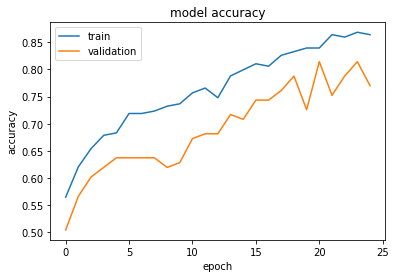

In [126]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [127]:
model5.save_weights("ex11-GRU_glove_wikipedia_bidirectional.h5")
print("Saved model to disk")

#model5.load_weights("ex11-GRU_glove_wikipedia_bidirectional.h5")
#print("Loaded model from disk")

Saved model to disk


### Let's compare the results

In [128]:
compare = pd.DataFrame([scores])
compare
# Current best results (SOTA) vary from 91 to 94% accuracy

,GRU_glove_wikipedia,GRU_glove_wikipedia_finetuned,GRU_word2vec_reviews,GRU_word2vec_reviews_bidirectional,GRU_word2vec_reviews_finetuned
0,"[0.4154591730890427, 0.8128342255551547]","[0.45590559429025906, 0.8181818191380424]","[0.6003967580948284, 0.6791443869391864]","[0.4561549504810476, 0.8288770031164037]","[0.5804643240523211, 0.7754010672875267]"
